# <center>Automatic Differentiation </center>

<a id="0"></a> <br>
# Table of Contents

1. [Automatic differentiation and gradients](#1)
1. [Gradient tapes](#2)
    1. [Partial derivatives and approximation errors](#11)
    1. [Gradients of a model](#3)
    1. [The watch method](#4)
    1. [Intermediate variables](#5)
1. [Vector-valued functions](#6)
1. [Higher-order gradients](#7)
1. [Cases where gradient returns None](#8)
1. [The Jacobian](#9)
1. [The Hessian](#10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.keras import TqdmCallback  # callback for progress bars
from tqdm.notebook import tqdm

In [ ]:
pi = tf.constant(np.pi)

#Approximating derivatives through finite differences
In the traditional numerical analysis, one way to approximate the derivatives of a function is to use finite differences. Another one is to use Fourier transform and its generalizations, known under the name of *spectral methods*. We will quickly review the method of finite differences here.

Suppose $u(x)$ is defined on discrete points $(x_0,x_1, \ldots, x_n)$. We define $u(x_i) = u_i$.
For simplicity, take the spacing between the points to be equal, $$x_{i+1}-x_i = \Delta x_i = h$$. The derivative is approximated as a direct copy from Calculus I books as
$$
u'(x_i)_+ \simeq \frac{1}{h} \left( u_{i+1} - u_i \right)
$$
That formula is called the *forward derivative*. Since $u_{i+1} = u_i + h u'(x_i) + O(h^2)$, the accuracy of above formula is $O(h)$. There is also backward derivative:
$$
u'(x_i)_- \simeq \frac{1}{h} \left( u_{i} - u_{i-1} \right) +O(h)
$$
and central derivative
$$
u'(x_i)_c \simeq \frac{1}{2h} \left( u_{i+1} - u_{i-1} \right) +O(h^2)
$$
Let us see how thse formulas work in practice and compare these traditional methods with automatic differentiation using neural networks.

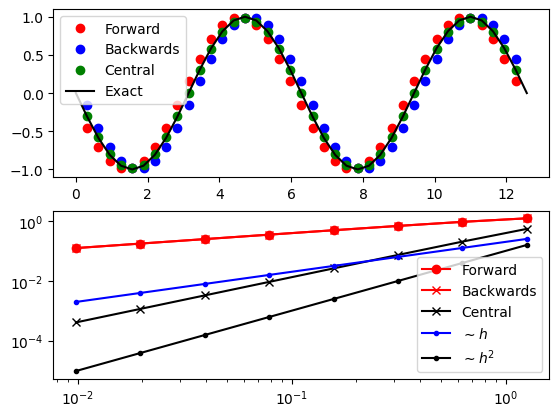

In [ ]:
npts = [11,21,41,81,161,321,641,1281]
err_p = np.zeros(len(npts))
err_m = np.zeros(len(npts))
err_c = np.zeros(len(npts))
fig,axs = plt.subplots(2,1)
h_a = np.zeros(len(npts))
for j in range(len(npts)):
  npts_j = npts[j]
  x= np.linspace(0,4*np.pi,npts[j])
  x_p = x[1:npts_j-1]
  x_m = x[1:npts_j-1]
  x_c = x[1:npts_j-1]
  h = np.diff(x)[0]
  h_a[j] = h
  y= np.cos(x)
  dy_p = np.diff(y)/h #numpy diff, by definition, takes y_{i+1}-y_i
  dy_m = dy_p[0:npts_j-2]
  dy_p = dy_p[1:npts_j-1] #Discarding 0th point to make dy_p and dy_m equal in size
  dy_c = (dy_p + dy_m)/2
  err_p[j]=np.linalg.norm(dy_p + np.sin(x_p))
  err_m[j]=np.linalg.norm(dy_m + np.sin(x_m))
  err_c[j]=np.linalg.norm(dy_c + np.sin(x_c))
  if j ==2:
    axs[0].plot(x_p,dy_p,'ro',x_m,dy_m,'bo',x_c,dy_c,'go',x,-np.sin(x),'k-')
    axs[0].legend(['Forward','Backwards','Central','Exact'])
axs[1].loglog(h_a,err_p,'ro-',h_a,err_m,'rx-',h_a,err_c,'kx-',h_a,0.2*h_a,'b.-',h_a,0.1*h_a**2,'k.-')
axs[1].legend(['Forward','Backwards','Central',r'$\sim h$',r'$\sim h^2$'])

<a id="1"></a>
# Automatic Differentiation and Gradients

In this notebook, we will learn how to compute gradients and use them in TensorFlow. This notebook is based on TensorFlow's documentation.

## The theory behind automatic differentiation ##
Automatic differentiation is closely connected with the backpropagation gradient method. This method allows to compute the derivative of the outputs with respect to inputs as follows.

Suppose we have a system of weights $\mathbf{W}$, and for shortness, we denote the matrix of weights on level $k$ as $\mathbb{W}^k$. We also denote the assembly of activation functions as $\mathbf{f} = (f_1, \ldots f_N)$ (for simplicity, we assume that the network has the same width $N$ on every level). The output of a neural network $\mathbf{Y}$ is connected with the input $\mathbf{X}$ as
$$
\mathbf{Y} = \mathbf{f} ( \mathbb{W}^N \cdot \mathbf{f} ( \mathbb{W}^{N-1} \cdot \mathbf{f} ( \ldots \mathbf{f}(\mathbb{W}^1 \cdot \mathbf{X} )))) = \mathbf{F}_{\mathbf{W}}(\mathbf{X}) \, .
$$
If the set of weights $\mathbf{W}$ is known, then, applying the chain rule, we can compute the derivatives of the outputs with respect to the inputs:
$$
\frac{\partial \mathbf{Y}}{\partial \mathbf{X}} =
\left(
  \mathbb{W}^N \cdot
\frac{\partial\mathbf{f}}{\partial\mathbf{Y}_N}
(\mathbf{Y}_N) \right)
\cdot
\left(
  \mathbb{W}^{N-1} \cdot
\frac{\partial\mathbf{f}}{\partial\mathbf{Y}_{N-1}}
(\mathbf{Y}_{N-1}) \right)
\cdot
\ldots
\cdot
\left(
  \mathbb{W}^{1} \cdot
\frac{\partial\mathbf{f}}{\partial\mathbf{Y}_{1}}
(\mathbf{X}) \right)
$$
Note that this derivative is exact if the set of weights is known. There are no approximations, finite gradients, dependence on data *etc*. Once the weights are known, the derivates are known to machine precision. The key is to find the right set of weights.

The method of automatic differentiation will be used in PINNs. We will approximate differential equations where we will use the output of a differential equation as the depdnent variable $\mathbf{Y}$ and the input, for example, the variables $(x,t)$, as $\mathbf{X}$. We will then find the weights $\mathbf{W}$ in such a way that the derivates of the outputs with respect to the input fit together as the differential equation.

The formula above is pretty complicated, but fortunately, it is implemented nicely and efficiently in TensorFlow. We will now learn how to compute these derivatives using Tensorflow notation. We need to learn about a few things, such as tensor variables and tapes.



<a id="2"></a>
# Gradient tapes

To differentiate an expression, TensorFlow breaks down the expression in question to small pieces using operations like $(+,\times, \circ, \ldots)$  and elementary functions $(x\mapsto x^n, \sin, \cos, \ln, \exp,\ldots)$ for which it has a registry of derivatives. This is done to speed up the computations of derivatives of the activation functions.

The API `tf.GradientTape` records the operations executed inside the context of a `tf.GradientTape` onto a "tape" (kind like an old-times tape recorder).

TensorFlow then uses that tape to compute the gradients of a "recorded" computation using [reverse mode differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

TensorFlow needs to operate on tensors. Tensors are sort of like arrays; those of you familiar with numpy will find them quite similar
* There are tensor constants, defined by `tf.constant`, for example:
`x = tf.constant(3.0)` simply means that x is a constant with the value of 3.0 that can be used in TensorFlow computations
* Most of the time you will use TensorFlow variables, for example
`x = tf.Variable(3.0)` means that x can vary and it's initial value is 3.0
* You can also create tensor arrays, for example
`x = tf.Tensor([[1.0,2.0],[3.0,4.0])`
* You can also specify the types of tensors explicitly
`x = tf.Tensor([[1,2],[3,4],dtype = tf.float16)`

You can read more about variables in TensorFlow here:
https://www.tensorflow.org/guide/tensor


Here is a simple example:

In [ ]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x*tf.cos(x)

Once you've recorded some operations, use `GradientTape.gradient(target, sources)` to calculate the gradient of some target relative to some source (often the model's variables):

In [ ]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

-1.4133525

Now let us write a function that takes as input a function $f$ defined elsewhere and a variable $x$ and returns the derivative $f'(x)$.

In [ ]:
def diff(func, x):
    """ computes the gradient of func at x"""
    with tf.GradientTape() as tape:

        tape.watch(x)
        y = func(x)

    y_x = tape.gradient(y, x)

    del tape

    return y_x

Let's test the derivation function above on the cosine function. Note that we need to use the TensforFlow's definition of cos, tf.cos(x), which is defined in such a way that the algorithms can take the derivative symbolically. TensorFlow will not understand the code if you try to use the numpy (np.cos(x)) or some other definition of cos. Make sure that you use the TensforFlow functions anywhere you need automatic differentiation!  

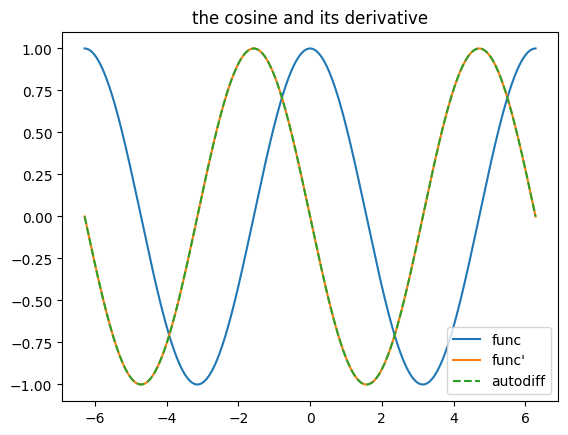

In [ ]:
def func(x):
  return tf.cos(x)

x = tf.linspace(-2*np.pi,2*np.pi,1000)
plt.plot(x, tf.cos(x), label="func")
plt.plot(x, -tf.sin(x), label="func'")
plt.plot(x, diff(func, x), "--", label="autodiff")
plt.title("the cosine and its derivative")
plt.legend()
plt.show()

The above examples use scalar variables, but `tf.GradientTape` supports tensors in general.

In [ ]:
w = tf.Variable(tf.random.normal((3, 2)))
b = tf.Variable(tf.zeros(2, dtype=tf.float32))
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

To get the gradient of `loss` with respect to both variables, you can pass both as sources to the `gradient` method. The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries and return the gradient structured the same way (see `tf.nest`).

In [ ]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

The gradient with respect to each source has the shape of the source:

In [ ]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


Here is the gradient calculation again, this time passing a dictionary of variables:

In [ ]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.5234532, -2.5451055], dtype=float32)>

### Question
What will happen if you calculate gradient with respect to regular `python` or `numpy` float?

In [ ]:
#@title answer

# GradientTape works only on Tensorflow Tensors (Constant or Variable).
# Calling it on Numpy arrays or python float will throw an error

x = np.array(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

tape.gradient(y, x)

ValueError: Passed in object 3.0 of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

<a id="3"></a>
## Partial derivatives and approximation errors

We will now show how to compute partial derivatives of $f(x,y) = \cos(x) \cos(y)$.

In [ ]:
def func(x):
  return tf.cos(x[:,0:1])*tf.cos(x[:,1:2])

In [ ]:
X_train = tf.random.uniform((1000,2), -pi, pi)
y_train = func(X_train)

model = tf.keras.Sequential([tf.keras.layers.Input(2),
tf.keras.layers.Dense(40, activation="tanh"),
tf.keras.layers.Dense(40, activation="tanh"),
tf.keras.layers.Dense(40, activation="tanh"),
tf.keras.layers.Dense(1)
])

In [ ]:
optim=tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-2)
model.compile(optim, loss="mse")

0epoch [00:00, ?epoch/s]

loss after 5000 epochs: 5.227001020102762e-05


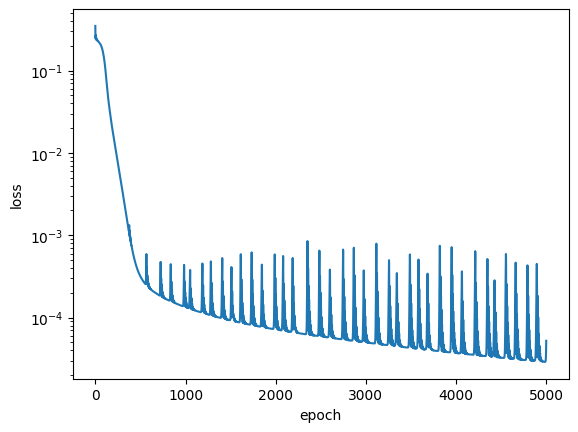

In [ ]:
history = model.fit(X_train, y_train, epochs=5000, verbose=0, batch_size = len(X_train),
                    callbacks=[TqdmCallback(verbose=0, miniters=100)])
print("loss after {} epochs: {}".format(history.epoch[-1]+1, history.history['loss'][-1]))
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

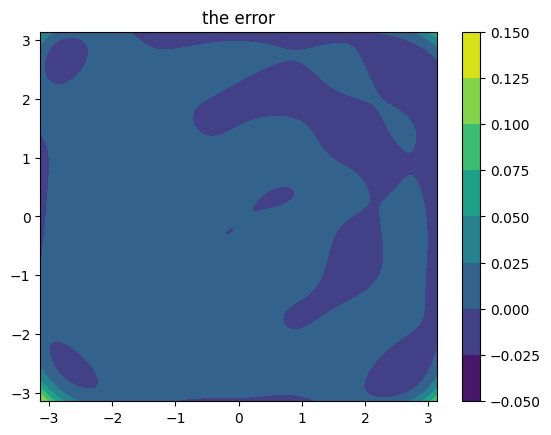

In [ ]:
x = tf.linspace(-pi, pi, 100)
y = tf.linspace(-pi, pi, 100)
X, Y = tf.meshgrid(x, y)
Z = tf.concat([tf.reshape(X, [10000, 1]), tf.reshape(Y, [10000, 1])], -1)
diff = model(Z) - func(Z)
diff = tf.reshape(diff, [100, 100])
plt.contourf(X, Y, diff)
plt.colorbar()
plt.title("the error")
plt.show()

In [ ]:
def diff(model, x):
    """ computes the gradient of func at x"""
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)
    y_x = tape.gradient(y, x)

    del tape

    return y_x

Let's explore the error at the level of derivatives. We'll compute the partial derivatives for both $f$ and the model along the line $y=\alpha x$. You can test with different values of $\alpha$. Note that we have to use tensorflow variables, such as tf.linspace and tf.reshape, not their numpy analogues.

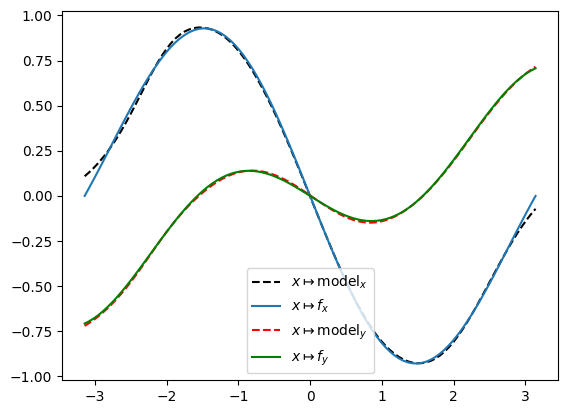

In [ ]:
alpha = 0.25
x = tf.reshape(tf.linspace(-pi,pi,100),(100,1))
y = alpha*tf.reshape(tf.linspace(-pi,pi,100),(100,1))
z = tf.concat([x, y], -1)
partial_der = diff(model, z)

plt.plot(x, partial_der[:,0:1], "k--", label="$x\mapsto\mathrm{model}_x$")
plt.plot(x, -tf.sin(x)*tf.cos(y), label="$x\mapsto f_x$")
plt.plot(x,partial_der[:,1:2], "r--", label="$x\mapsto\mathrm{model}_y$")
plt.plot(x, -tf.sin(y)*tf.cos(x), "green", label="$x\mapsto f_y$")
plt.legend()
plt.show()

### Question

Plot partial derivatives, like shown right above, for different $\alpha$ in $y=\alpha x$. Try also curve-linear slice (e.g. $y=cos(x)$).


<a id="3"></a>
## Gradients of a model

In order to minimize the loss of a model, TensorFlow needs  to calculate gradients with respect to the model's trainable parameters.  This is a very useful shorthand notation: you don't have to find out by hand which parameters are trainable and which are not. The trainable parameters of a TensorFlow model, that is a subclasses of `tf.Module`, are stored in the property `model.trainable_variables`. Let's test with a simple example.


In [ ]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  y = layer(x)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(y, layer.trainable_variables)

In [ ]:
print("the kernel of layer is:", layer.trainable_variables[0])

the kernel of layer is: <tf.Variable 'dense_4/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.28632247,  0.7086086 ],
       [-0.73002553, -0.45274937],
       [ 0.9424386 , -0.18539   ]], dtype=float32)>


In [ ]:
print("the bias of layer is:", layer.trainable_variables[1])

the bias of layer is: <tf.Variable 'dense_4/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>


In [ ]:
print("the gradients of layer wrt kernel and bias are:", grad)

the gradients of layer wrt kernel and bias are: [<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 0.],
       [2., 0.],
       [3., 0.]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>]


### Question

Create a more complex neural-network model, add more layers, different activation function. Look at how output of `tape.gradient` changes. You can modify the code snippet below.


In [ ]:
#@title code snippet

layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  y = layer(x)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(y, layer.trainable_variables)

<a id="4"></a>
## The watch method

The default behavior is to record all operations after accessing a trainable `tf.Variable`. The reasons for this are:

* The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
* The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
* The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.

For example, the following fails to calculate a gradient because the `tf.Tensor` is not "watched" by default, and the `tf.Variable` is not trainable:

In [ ]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


You can list the variables being watched by the tape using the `GradientTape.watched_variables` method:

In [ ]:
[var.name for var in tape.watched_variables()]

['x0:0']

`tf.GradientTape` provides the tools to define the variables to watch and perform operations with. These variables that give the user control over what is or is not watched.

To record gradients with respect to a `tf.Tensor`, you need to call `GradientTape.watch(x)`:

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

# dy = 2x * dx
y_x = tape.gradient(y, x)
print(y_x.numpy())

6.0


Conversely, to disable the default behavior of watching all `tf.Variables`, set `watch_accessed_variables=False` when creating the gradient tape. This calculation uses two variables, but only connects the gradient for one of the variables:

In [ ]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

Since `GradientTape.watch` was not called on `x0`, no gradient is computed with respect to it. The gradients can only be computed with respect to 'watched' variables.

In [ ]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


<a id="5"></a>
## Intermediate variables

You can also request gradients of the output with respect to intermediate values computed inside the `tf.GradientTape` context. This trick is very useful if you have a lot of variables which may consume a lot of resources.

In [ ]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


By default, the resources held by a `GradientTape` are released as soon as the `GradientTape.gradient` method is called. To compute multiple gradients over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the `gradient` method as resources are released when the tape object is garbage collected. For example:

In [ ]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [ ]:
del tape   # Delete the tape

### Question

Calculate gradient of $cos(x)sin(x)$ with respect to $x$ and $sin(x)$ (treat $sin(x)$ as an intermediate variable)

<a id="6"></a>
#Vector-valued functions



`tf.GradientTape.gradient` only computes gradients of scalar functions. So, if you have a vector-valued function and you want to compute it gradient, you would need to compute the gradient of each component separately. Say for example you want to compute the gradient of $y
=(x^2, 1/x)$. You have to do it as below.

In [ ]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


If you do `GradientTape(y, x)` for a vector_valued function $y$, GradientTape will return *the sum* of the gradients of the component of $y$. Be careful using this tool or you may end up computing gradients incorrectly!

In [ ]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


Another example.

In [ ]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


On the other hand, if you use this tool properly, it makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

If you need a separate gradient for each item, refer to [The Jacobian](#9).

In some cases you can skip the Jacobian. For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent:

In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

y_x = tape.gradient(y, x)

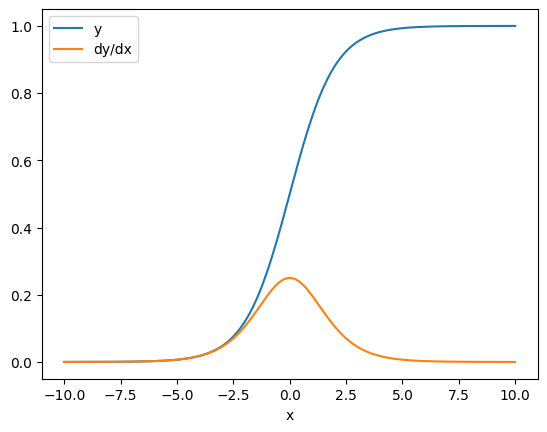

In [ ]:
plt.plot(x, y, label='y')
plt.plot(x, y_x, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

### Question

Calculate gradient $\frac{\partial (Ax) \cdot x}{\partial x}$ using GradientTape, where $Ax$ is matrix-vector multiplication, $\cdot$ is inner product of two vectors. Matrix and vector values can be arbitrary.

In [ ]:
#@title Answer

x = tf.random.normal((3, 1))
A = tf.random.normal((3, 3))

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.reduce_sum((A @ x) * x)

dy_dx = tape.gradient(y, x)

print(y)
print(dy_dx)

tf.Tensor(-2.661419, shape=(), dtype=float32)
tf.Tensor(
[[-2.791439 ]
 [ 0.7594054]
 [-2.2537389]], shape=(3, 1), dtype=float32)


<a id="6"></a>
#Higher-order gradients

Operations inside of the `tf.GradientTape` context manager are recorded for automatic differentiation. If gradients are computed in that context, then the gradient computation is recorded as well. As a result, the exact same API works for higher-order gradients as well.

One way of computing higher-order derivatives is by using nested tapes.



In [ ]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x ** 3

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


Another way of is by using the persistent mode in a tape. The following code does the same thing as in the previous cell (although see warning about efficiency below)

In [ ]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape(persistent=True) as tape:
  y = x**3

  # Compute the gradient inside the outer  context manager
  dy_dx = tape.gradient(y, x)

d2y_dx2 = tape.gradient(dy_dx, x)
del tape

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


Let's differentiate $x\mapsto e^x$ twice.

In [ ]:
t = tf.linspace(0, 5, 100)

with tf.GradientTape() as tape2:
  with tf.GradientTape() as tape1:

    # make sure to record t on both tapes
    tape1.watch(t)
    tape2.watch(t)

    y = tf.exp(t)

  dy_dt = tape1.gradient(y, t)
d2y_dt2 = tape2.gradient(dy_dt, t)


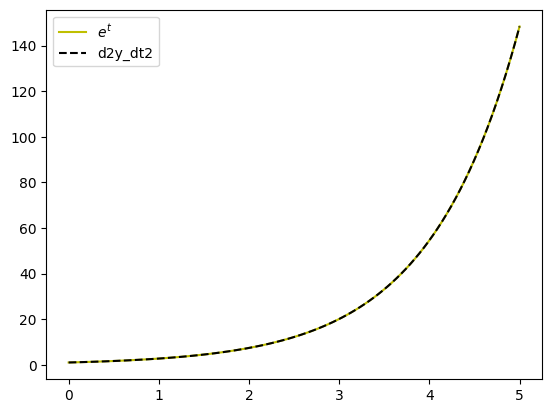

In [ ]:
plt.plot(t, tf.exp(t), "y", label="$e^t$")
plt.plot(t, d2y_dt2, "k--", label="d2y_dt2")
plt.legend()
plt.show()

### Question

Calculate second-order derivative of $y=e^{-x^2}$ using GradientTape with respect to $x^2$, **not** just $x$.

In [ ]:
#@title Answer

x = tf.constant(2.0)

with tf.GradientTape() as g:
  g.watch(x)
  with tf.GradientTape() as gg:
    gg.watch(x)
    z = x**2
    y = tf.exp(-z)
  dy_dx = gg.gradient(y, z)  # dy_dx = 2 * x
d2y_dx2 = g.gradient(dy_dx, z)  # d2y_dx2 = 2

print(y)
print(dy_dx)
print(d2y_dx2)

tf.Tensor(0.01831564, shape=(), dtype=float32)
tf.Tensor(-0.01831564, shape=(), dtype=float32)
tf.Tensor(0.01831564, shape=(), dtype=float32)


### Question

Calculate $\frac{dy}{dz} \cdot \frac{d^2y}{dx^2}$ where $y=cos(z)$ and $z=e^{-x}$.

In [ ]:
#@title Answer

x = tf.constant(2.0)

with tf.GradientTape() as g:
  g.watch(x)
  with tf.GradientTape() as gg:
    gg.watch(x)
    z = tf.exp(-x)
    y = tf.cos(z)
  dy_dz, dy_dx = gg.gradient(y, [z, x])
d2y_dx2 = g.gradient(dy_dx, x)

dd = dy_dz * d2y_dx2

print(y)
print(dy_dz)
print(d2y_dx2)
print(dd)

tf.Tensor(0.9908562, shape=(), dtype=float32)
tf.Tensor(-0.13492253, shape=(), dtype=float32)
tf.Tensor(-0.03640794, shape=(), dtype=float32)
tf.Tensor(0.0049122516, shape=(), dtype=float32)


<a id="8"></a>
# Cases where `gradient` returns `None`

When the target is independent of the variable, `gradient` will return `None`. You would think from Calculus that the answer actually should be zero, but this is the notation TensorFlow uses that you need to be aware of. But there are other ways to get `None` which gives you subsequent errors in execution. We will list some of the most common cases below.


In [ ]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


## 1. When the user replaced a variable with a tensor

In the section [The watch method](#4) you saw that the tape will automatically watch a `tf.Variable` but not a `tf.Tensor`.

One common error is to inadvertently replace a `tf.Variable` with a `tf.Tensor`, instead of using `Variable.assign` to update the `tf.Variable`. Here is an example:

In [ ]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1 # This should be `x.assign_add(1)`

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


Explanation:

In [ ]:
x = tf.Variable(2.0)
print("x is:", x)
print("x+1 is:", x+1)
print("x.assign_add(1) is:", x.assign_add(1))

x is: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>
x+1 is: tf.Tensor(3.0, shape=(), dtype=float32)
x.assign_add(1) is: <tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=3.0>


## 2. The user accidentally did calculations outside of TensorFlow

The tape can't record the gradient path if the calculation exits TensorFlow.
For example:

In [ ]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # ERROR! This step is calculated with NumPy:
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


## 3. The dtype of the watched tensor must be floating

Integers and strings are not differentiable. If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable, but it's easy to accidentally create an `int` constant or variable if you don't specify the `dtype`.

In [ ]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


TensorFlow doesn't automatically cast between types, so, in practice, you'll often get a type error instead of a missing gradient.

### Question

Check what happens if you do math operations (and gradient) with mixed Tensorflow types (e.g. $+$ or $*$).

In [ ]:
x = tf.constant(10)
y = tf.constant(2.0)

# x + y
# x*y
# x * 2.0

<a id="9"></a>
#The Jacobian


Suppose $f \colon \mathbb{R}^n \to \mathbb{R}^m$ is a function such that each of its first-order partial derivatives exist on $\mathbb{R}^n$. We can write $f$ as $f(x) = (f_1(x),\ldots , f_m(x))$, where $f_i\colon \mathbb{R}^n \to \mathbb{R}$. Then the Jacobian matrix of $f$ at $a\in \mathbb{R}^n$, denoted $J(a)$,  is the $m\times n$ matrix whose $(i,j)$th entry is

$$J _{ij}(a)={\frac {\partial f_{i}(a)}{\partial x_{j}}}.$$


As we have seen in the previous examples `tf.GradientTape.gradient` is less convenient when dealing with vector-valued functions. A more suitable method is the `tf.GradientTape.jacobian` method.

Note that:

* Like `gradient`: The `sources` argument can be a tensor or a container of tensors.
* Unlike `gradient`: The `target` tensor must be a single tensor.



In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)
a = tf.Variable(0.0)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x + a)

dy_da = tape.jacobian(y, a)

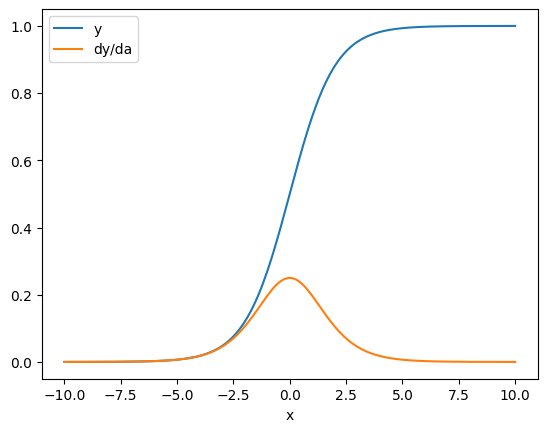

In [ ]:
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_da, label='dy/da')
plt.legend()
plt.xlabel('x')
plt.show()


We learn in Calculus that the Jacobian of the identity function $\mathbf{y}=\mathbf{x}$ is the identity matrix of the proper size. For example, if $\mathbf{x}$ and $\mathbf{y}$ are $n$-dimensional vectors, then the identity matrix has the dimension $n \times n$:
$$
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \mathbb{I}_{n \times n}
$$
Let's check that in TensorFlow.

In [ ]:
def identity(x):
  return x

In [ ]:
x = tf.Variable([1., 2.])

with tf.GradientTape() as tape:
  y = identity(x)

tape.jacobian(y, x).numpy()

array([[1., 0.],
       [0., 1.]], dtype=float32)

Let's try another example.

In [ ]:
x = tf.Variable([1., 2.])

with tf.GradientTape() as tape:
  y = x[0]**2 + x[1]**2
  y_x = tape.jacobian(y, x)

print(y_x)

tf.Tensor([2. 4.], shape=(2,), dtype=float32)


### Question

Calculate jacobian of $\frac{\partial (Ax) \cdot x}{\partial x}$ with respect vector $x$, where $Ax$ is matrix-vector multiplication, $\cdot$ is inner product of two vectors.

In [ ]:
#@title Answer

x = tf.random.normal((3, 1))
A = tf.random.normal((3, 3))

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.reduce_sum((A @ x) * x)

dy_dx = tape.jacobian(y, x)

# print(y)
print((A @ x)[:, 0] + tf.reduce_sum(A * x, axis=0))  # Expected answer
print(dy_dx)

tf.Tensor([ 0.5589678 -2.7370458 -1.3386703], shape=(3,), dtype=float32)
tf.Tensor(
[[ 0.5589678]
 [-2.7370458]
 [-1.3386703]], shape=(3, 1), dtype=float32)


<a id="10"></a>
#The Hessian


Suppose $f \colon \mathbb{R}^n \to \mathbb{R}$ is a function such that each of its first-order partial derivatives exist and is differentiable.  The Hessian matrix of $f$ at $a\in \mathbb{R}^n$, denoted $H(a)$,  is the $n\times n$ matrix whose $(i,j)$th entry is

$$H _{ij}(a)=\frac {\partial^2 f(a)}{\partial x_i \partial x_j}.$$

`tf.GradientTape` doesn't give a direct method for computing the Hessian matrix, you need to  call the `tf.GradientTape.jacobian` method twice in order to compute it. The Hessian of $f\colon \mathbb{R}^2 \to \mathbb{R},\, f(x,y)=\frac{1}{2}(x^2+y^2)$ is the $2\times 2$ identity matrix as shown below.

In [ ]:
x = tf.Variable([1., 2.])

with tf.GradientTape() as tape1:
  with tf.GradientTape() as tape2:
    y = 0.5*(x[0]**2 + x[1]**2)
  y_x = tape2.jacobian(y, x)

y_xx = tape1.jacobian(y_x, x)

print(y_xx)

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


Note: The Hessian matrix contains `N**2` parameters. When $N$ is large, the number of parameters in Hessian can become unrealistically large to hold in the memory, for example. The example below is included more as a demonstration of how to use the `tf.GradientTape.jacobian` method, and is not an endorsement of calculations of Hessian directly, with storing and using it in the program. In general, for large dimensional spaces you need to be aware of the memory requirements for high-dimensional tensors.

In [ ]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

In [ ]:
print(f'layer.kernel.shape: {layer1.kernel.shape}')
print(f'h.shape: {h.shape}')

layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)


In [ ]:
n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

In [ ]:
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()

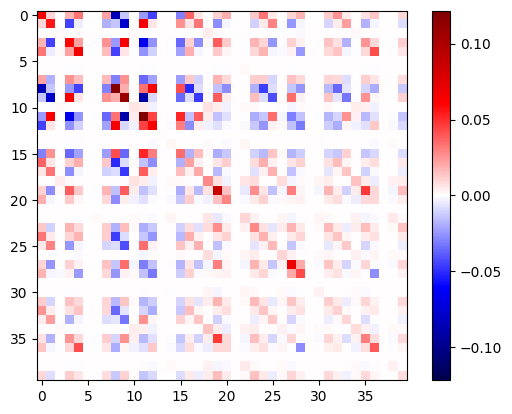

In [ ]:
imshow_zero_center(h_mat)

# Accuracy of neural networks vs finite differences

In [ ]:
def diff_nn(model, x):
    """ computes the gradient of func at x"""
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)
    y_x = tape.gradient(y, x)

    del tape
    return y_x

def train_nn(X_train, y_train):
  model = tf.keras.Sequential([tf.keras.layers.Input(1),
  tf.keras.layers.Dense(50, activation="tanh"),
  tf.keras.layers.Dense(50, activation="tanh"),
  tf.keras.layers.Dense(1)
  ])

  optim=tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-2)
  model.compile(optim, loss="mse")

  # weights = abs(X_train - X_train[len(X_train) // 2])**2
  # weights = weights / weights.max()
  # wmin = 0.1
  # weights = weights * (1.0 - wmin) + wmin

  history = model.fit(X_train, y_train, epochs=5000, verbose=0,
                      batch_size = X_train.size,
                      # sample_weight=weights
                      )

  dy_nn = diff_nn(model, tf.constant(X_train))
  return dy_nn

  0%|          | 0/4 [00:00<?, ?it/s]

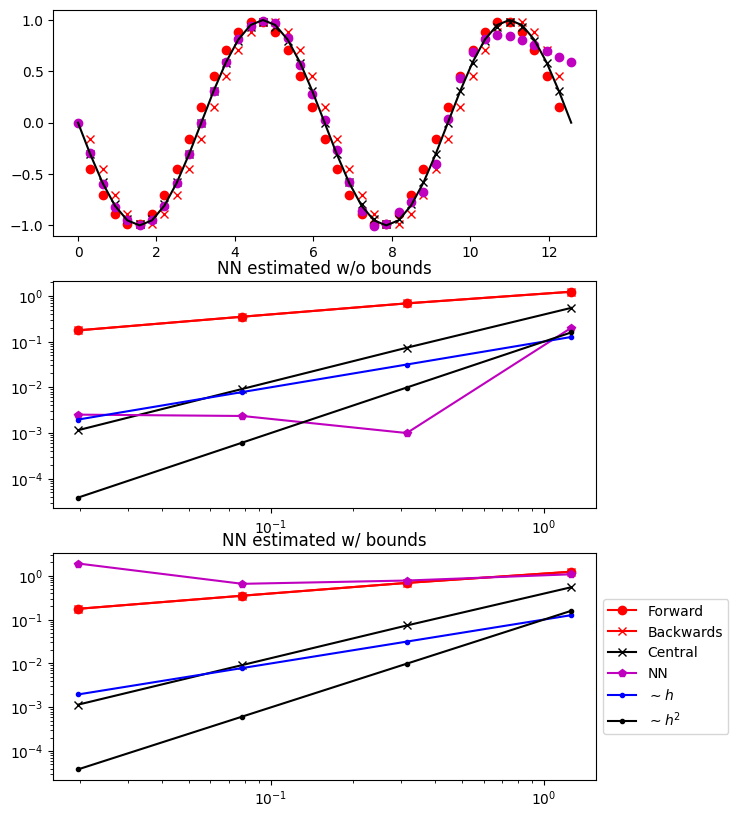

In [ ]:
npts = [11,41,161,641]
err_p = np.zeros(len(npts))
err_m = np.zeros(len(npts))
err_c = np.zeros(len(npts))
err_nn_full = np.zeros(len(npts))
err_nn_in = np.zeros(len(npts))
fig,axs = plt.subplots(3,1, figsize=(7, 10))
h_a = np.zeros(len(npts))
for j in tqdm(range(len(npts))):
  npts_j = npts[j]
  x = np.linspace(0,4*np.pi,npts[j])
  x_p = x[1:npts_j-1]
  x_m = x[1:npts_j-1]
  x_c = x[1:npts_j-1]
  h = np.diff(x)[0]
  h_a[j] = h
  y = np.cos(x)
  dy_p = np.diff(y)/h #numpy diff, by definition, takes y_{i+1}-y_i
  dy_m = dy_p[0:npts_j-2]
  dy_p = dy_p[1:npts_j-1] #Discarding 0th point to make dy_p and dy_m equal in size
  dy_c = (dy_p + dy_m)/2
  err_p[j]=np.linalg.norm(dy_p + np.sin(x_p))
  err_m[j]=np.linalg.norm(dy_m + np.sin(x_m))
  err_c[j]=np.linalg.norm(dy_c + np.sin(x_c))

  # Neural-network derivative
  dy_nn = train_nn(x, y)
  y_true = -np.sin(x)

  cut_bounds = int(0.2 * len(x))
  in_slice = slice(cut_bounds, -cut_bounds)
  err_nn_full[j] = np.linalg.norm(dy_nn - y_true)
  err_nn_in[j] = np.linalg.norm(dy_nn[cut_bounds] - y_true[cut_bounds])

  if j == 1:
    axs[0].plot(x_p,dy_p,'ro',x_m,dy_m,'rx',x_c,dy_c,'kx', x,dy_nn,'mo',
                x,y_true,'k-')

axs[1].loglog(h_a,err_p,'ro-',h_a,err_m,'rx-',h_a,err_c,'kx-',
              h_a,err_nn_in,'mp-', h_a,0.1*h_a,'b.-',h_a,0.1*h_a**2,'k.-')
axs[1].set_title('NN estimated w/o bounds')
axs[2].loglog(h_a,err_p,'ro-',h_a,err_m,'rx-',h_a,err_c,'kx-',
              h_a,err_nn_full,'mp-', h_a,0.1*h_a,'b.-',h_a,0.1*h_a**2,'k.-')
axs[2].set_title('NN estimated w/ bounds')
axs[2].legend(['Forward','Backwards','Central', 'NN', r'$\sim h$',r'$\sim h^2$'],
              loc='center left', bbox_to_anchor=(1, 0.5))

## Noise influence

  0%|          | 0/4 [00:00<?, ?it/s]

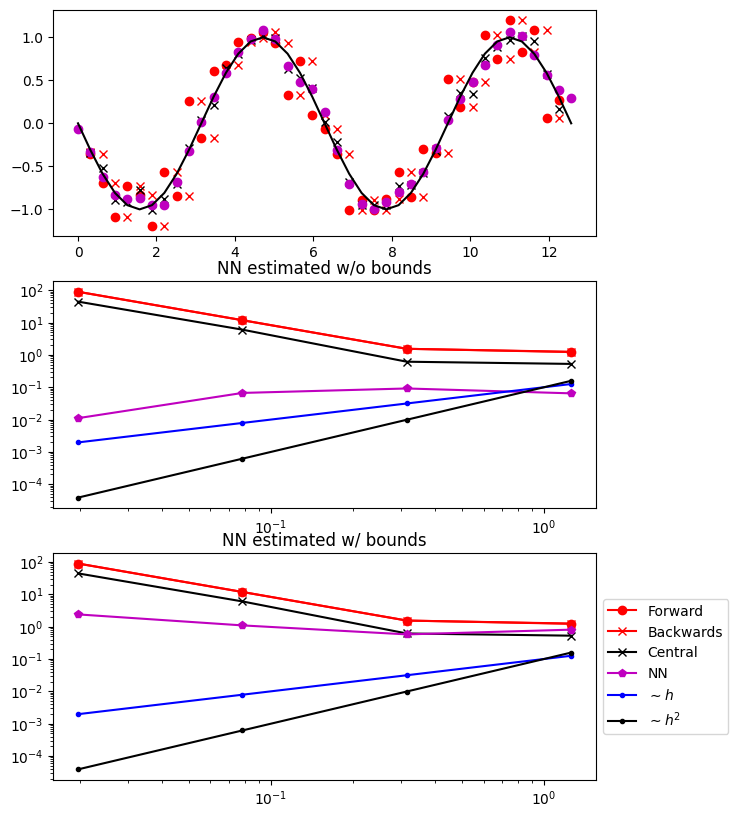

In [ ]:
npts = [11,41,161,641]
err_p = np.zeros(len(npts))
err_m = np.zeros(len(npts))
err_c = np.zeros(len(npts))
err_nn_full = np.zeros(len(npts))
err_nn_in = np.zeros(len(npts))
fig,axs = plt.subplots(3,1, figsize=(7, 10))
h_a = np.zeros(len(npts))
for j in tqdm(range(len(npts))):
  npts_j = npts[j]
  x = np.linspace(0,4*np.pi,npts[j])
  x_p = x[1:npts_j-1]
  x_m = x[1:npts_j-1]
  x_c = x[1:npts_j-1]
  h = np.diff(x)[0]
  h_a[j] = h

  y_true = np.cos(x)
  y = y_true + np.random.randn(*x.shape) * 0.05  # introducing noise ----------

  dy_p = np.diff(y)/h #numpy diff, by definition, takes y_{i+1}-y_i
  dy_m = dy_p[0:npts_j-2]
  dy_p = dy_p[1:npts_j-1] #Discarding 0th point to make dy_p and dy_m equal in size
  dy_c = (dy_p + dy_m)/2
  err_p[j]=np.linalg.norm(dy_p + np.sin(x_p))
  err_m[j]=np.linalg.norm(dy_m + np.sin(x_m))
  err_c[j]=np.linalg.norm(dy_c + np.sin(x_c))

  # Neural-network derivative
  dy_nn = train_nn(x, y)
  dy_true = -np.sin(x)

  cut_bounds = int(0.2 * len(x))
  in_slice = slice(cut_bounds, -cut_bounds)
  err_nn_full[j] = np.linalg.norm(dy_nn - dy_true)
  err_nn_in[j] = np.linalg.norm(dy_nn[cut_bounds] - dy_true[cut_bounds])

  if j == 1:
    axs[0].plot(x_p,dy_p,'ro',x_m,dy_m,'rx',x_c,dy_c,'kx', x,dy_nn,'mo',
                x,-np.sin(x),'k-')

axs[1].loglog(h_a,err_p,'ro-',h_a,err_m,'rx-',h_a,err_c,'kx-',
              h_a,err_nn_in,'mp-', h_a,0.1*h_a,'b.-',h_a,0.1*h_a**2,'k.-')
axs[1].set_title('NN estimated w/o bounds')
axs[2].loglog(h_a,err_p,'ro-',h_a,err_m,'rx-',h_a,err_c,'kx-',
              h_a,err_nn_full,'mp-', h_a,0.1*h_a,'b.-',h_a,0.1*h_a**2,'k.-')
axs[2].set_title('NN estimated w/ bounds')
axs[2].legend(['Forward','Backwards','Central', 'NN', r'$\sim h$',r'$\sim h^2$'],
              loc='center left', bbox_to_anchor=(1, 0.5))